In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, RepeatVector
import tensorflow as tf
import os
from keras.layers import TimeDistributed
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
import joblib
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
"""
Training Data
"""
#data = pd.read_csv("traj_100_seq_train.csv")
data = pd.read_csv("data/traj_200_seq_train.csv")
data.describe()

,Unnamed: 0,Vehicle_ID,X,Y,X_REL,Y_REL
count,271800.00000,271800.000000,271800.000000,271800.000000,2.718000e+05,2.718000e+05
mean,135899.50000,138713.465784,151.187284,-33.894814,2.749781e-07,1.825982e-06
std,78462.04592,79858.222190,0.001347,0.000500,8.489875e-05,6.043587e-05
min,0.00000,0.000000,151.184733,-33.895679,-2.552615e-04,-2.656096e-04
25%,67949.75000,69800.000000,151.186314,-33.895216,-4.766988e-05,-3.103745e-05
50%,135899.50000,140000.000000,151.187419,-33.894842,-7.275850e-07,7.409000e-07
75%,203849.25000,208000.000000,151.187992,-33.894474,4.831394e-05,3.432616e-05
max,271799.00000,275800.000000,151.192349,-33.892186,2.641862e-04,2.736990e-04


In [4]:
"""
Preprocess data, removed torch tensors return type, now np arrays
"""
def preprocess_dataset(data, max = 10, max_len = 40, input_len = 30):
    scaler = MinMaxScaler(feature_range=(0, max))
    data[['X_REL', 'Y_REL']] = scaler.fit_transform(data[['X_REL', 'Y_REL']])
    #joblib.dump(scaler, "100seq.save") 
    #scaler = joblib.load("scaler_100_seq_v3.save")
    #data[['X_REL', 'Y_REL']] = scaler.transform(data[['X_REL', 'Y_REL']])
    unique_peds = data['Vehicle_ID'].unique()
    unique_peds = sorted(unique_peds)
    inputs = []
    outputs = []
    indexes = []
    for ped in unique_peds:
        if (len(data[data['Vehicle_ID'] == ped]) >= max_len):
          seq_inner = []
          indexes_inner = []
          i = 0
          for indx, row in data[data['Vehicle_ID'] == ped].iterrows():
            x = round(row['X_REL'])
            y = round(row['Y_REL'])
            ## Cantor pairing function:
            bin = y * max + x
            i += 1
            if i == max_len:
              break
            seq_inner.append(int(bin))
            indexes_inner.append(ped)
          inputs.append([seq_inner[0:input_len]])
          outputs.append([seq_inner[input_len + 1:]])
          indexes.append([indexes_inner])
        
    train_inputs, test_inputs, train_targets, test_targets, train_indx, test_indx = train_test_split(inputs, outputs, indexes, train_size=0.7, random_state=200)
    return np.array(train_inputs), np.array(test_inputs), np.array(train_targets), np.array(test_targets), train_indx, test_indx

In [5]:
train_data_inputs, test_data_inputs, train_data_targets, test_data_targets, train_indx, test_indx = preprocess_dataset(data, max = 30, max_len = 200, input_len = 100)

In [6]:
train_data_inputs

array([[[465, 465, 465, ..., 501, 501, 501]],

       [[465, 465, 465, ..., 399, 399, 399]],

       [[465, 465, 465, ..., 398, 398, 398]],

       ...,

       [[465, 465, 465, ..., 493, 493, 493]],

       [[465, 465, 465, ..., 531, 531, 531]],

       [[465, 465, 465, ..., 441, 441, 441]]])

In [7]:

train_data_inputs = train_data_inputs.reshape(train_data_inputs.shape[0], train_data_inputs.shape[2], 1)
train_data_targets = train_data_targets.reshape(train_data_targets.shape[0], train_data_targets.shape[2], 1)


In [8]:

test_data_inputs = test_data_inputs.reshape(test_data_inputs.shape[0], test_data_inputs.shape[2], 1)
test_data_targets = test_data_targets.reshape(test_data_targets.shape[0], test_data_targets.shape[2], 1)


In [11]:
test_data_targets.shape

(408, 98, 1)

In [14]:
vocab_size = (30 * 30) + 30
input_len = 100
target_len = 98

In [41]:
#https://towardsdatascience.com/how-to-build-an-encoder-decoder-translation-model-using-lstm-with-python-and-keras-a31e9d864b9b
#https://machinelearningmastery.com/how-to-use-an-encoder-decoder-lstm-to-echo-sequences-of-random-integers/

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model = Sequential()
model.add(tf.keras.layers.Input(shape=(input_len,)))
model.add(tf.keras.layers.Embedding(vocab_size, 256))#, input_length = input_len))

model.add(LSTM(256, activation='tanh', return_sequences=False, stateful=False, dropout=0.20))

model.add(RepeatVector(target_len))
model.add(LSTM(256, return_sequences=True, activation='tanh', stateful=False, dropout=0.20))

model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))
          
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 256)          238080    
_________________________________________________________________
lstm_10 (LSTM)               (None, 256)               525312    
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 98, 256)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 98, 256)           525312    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 98, 930)           239010    
Total params: 1,527,714
Trainable params: 1,527,714
Non-trainable params: 0
_________________________________________________________________


In [42]:
model_results = model.fit(train_data_inputs, train_data_targets, batch_size=1, epochs=65, callbacks=[callback], validation_data=(test_data_inputs, test_data_targets))

Epoch 1/65
951/951 [==============================] - 16s 17ms/step - loss: 6.0768 - accuracy: 0.0231 - val_loss: 5.7119 - val_accuracy: 0.0214
Epoch 2/65
951/951 [==============================] - 15s 16ms/step - loss: 5.3377 - accuracy: 0.0434 - val_loss: 5.2775 - val_accuracy: 0.0726
Epoch 3/65
951/951 [==============================] - 15s 16ms/step - loss: 4.8992 - accuracy: 0.0718 - val_loss: 4.7860 - val_accuracy: 0.0729
Epoch 4/65
951/951 [==============================] - 15s 16ms/step - loss: 4.4624 - accuracy: 0.0915 - val_loss: 4.3020 - val_accuracy: 0.0929
Epoch 5/65
951/951 [==============================] - 15s 16ms/step - loss: 4.1308 - accuracy: 0.1071 - val_loss: 4.0576 - val_accuracy: 0.1382
Epoch 6/65
951/951 [==============================] - 15s 16ms/step - loss: 3.9301 - accuracy: 0.1225 - val_loss: 4.1298 - val_accuracy: 0.0943
Epoch 7/65
951/951 [==============================] - 15s 16ms/step - loss: 3.6722 - accuracy: 0.1494 - val_loss: 3.7422 - val_accuracy:

951/951 [==============================] - 15s 16ms/step - loss: 1.2024 - accuracy: 0.5544 - val_loss: 2.1618 - val_accuracy: 0.4344
Epoch 58/65
951/951 [==============================] - 15s 16ms/step - loss: 1.2260 - accuracy: 0.5471 - val_loss: 2.0572 - val_accuracy: 0.4601
Epoch 59/65
951/951 [==============================] - 15s 16ms/step - loss: 1.2141 - accuracy: 0.5477 - val_loss: 2.1454 - val_accuracy: 0.4302
Epoch 60/65
951/951 [==============================] - 15s 16ms/step - loss: 1.1528 - accuracy: 0.5683 - val_loss: 2.0774 - val_accuracy: 0.4637
Epoch 61/65
951/951 [==============================] - 15s 16ms/step - loss: 1.1249 - accuracy: 0.5759 - val_loss: 2.0970 - val_accuracy: 0.4575
Epoch 62/65
951/951 [==============================] - 15s 16ms/step - loss: 1.1926 - accuracy: 0.5611 - val_loss: 2.2098 - val_accuracy: 0.4270
Epoch 63/65
951/951 [==============================] - 15s 16ms/step - loss: 1.1755 - accuracy: 0.5699 - val_loss: 2.1503 - val_accuracy: 0.45

In [ ]:
p = model.predict(test_data_inputs[0:1])
print(p.shape)
print(p)

In [45]:
model.save('New_LSTM_200seq.h5')

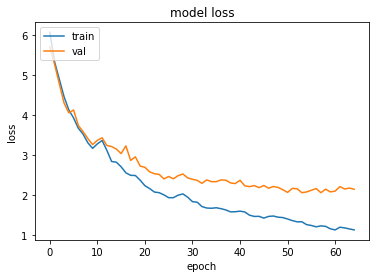

In [46]:
#plotting losses, https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
plt.plot(model_results.history['loss'])
plt.plot(model_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
input_len = 20
target_len = 28

In [ ]:
def get_predictions(model, data_source_inputs, data_source_targets):

    predictions = []
    ground_truths = []
    inputs = []
    for i in range(0, data_source_inputs.shape[0], 1):
        res = model.predict(data_source_inputs[i:i+1])
        for j in range(target_len):
            ground_truths.append(data_source_targets[i].squeeze().tolist())
            predictions.append((tf.argmax(res[0,:,:], axis=1)).numpy().tolist())
            if j < 20:
                inputs.append(int(data_source_inputs[i][j]))
            
    return inputs, ground_truths, predictions

In [ ]:
inputs_list, target_list, preds_list = get_predictions(model, test_data_inputs, test_data_targets)

In [ ]:
len(inputs_list)

In [ ]:
import math
def calculate_eucledian_mse(targets, preds):
  err = 0
  for indx in range(0, len(targets)):
    x_target = targets[indx] % 100
    y_target = targets[indx] / 100

    x_preds = preds[indx] % 100
    y_preds = preds[indx] / 100

    dist = math.hypot(x_target - x_preds, y_target - y_preds)
    err += dist
  return (err / len(targets))

In [ ]:
calculate_eucledian_mse(target_list, preds_list)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def vis_trajectory_scatter(input_list, target_list, preds_list, lag_time = 1.0):
    plt.figure(figsize=(3,3))
    for i in range(0, len(input_list)):

        inputs = input_list[i]
        targets = target_list[i]
        preds = preds_list[i]
        
        xy_inputs = []
        xy_preds = []
        xy_target = []

        x = inputs % 100
        y = inputs / 100 
        xy_inputs.extend([x, y])

        x = preds % 100
        y = preds / 100 
        xy_preds.extend([x, y])

        x = targets % 100
        y = targets / 100 
        xy_target.extend([x, y])
    print(xy_inputs)
    print(xy_preds)
    print(xy_target)
    """

    x_inp, y_inp = zip(*xy_inputs)
    x_tar, y_tar = zip(*xy_target)
    x_pred, y_pred = zip(*xy_preds)

    plt.scatter(x_inp,y_inp)
    plt.scatter(x_tar,y_tar, color='r')
    plt.scatter(x_pred,y_pred)

    plt.xlim(0, 100)
    plt.ylim(0, 100)

    plt.show()
    print("Input: ", xy_inputs)
    print("Preds: ", xy_preds)
    print("Truth: ", xy_target)
    time.sleep(lag_time)
    """

In [ ]:
vis_trajectory_scatter(inputs_list, target_list, preds_list)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def vis_trajectory_scatter(input_list, target_list, preds_list, lag_time = 1.0):
  
  for i in range(1 ,1000, 20):

    plt.figure(figsize=(5,5))
    #inputs = input_list[i]
    targets = target_list[i]
    preds = preds_list[i]

    xy_inputs = []
    xy_preds = []
    xy_target = []

    """
    for inp in inputs:
      x = inp % 100
      y = inp / 100 

      xy_inputs.append([x, y])
    """
    for inp in preds:
      x = inp % 100
      y = inp / 100 
      xy_preds.append([x, y])

    for inp in targets:
      x = inp % 100
      y = inp / 100 
      xy_target.append([x, y])

    #x_inp, y_inp = zip(*xy_inputs)
    x_tar, y_tar = zip(*xy_target)
    x_pred, y_pred = zip(*xy_preds)

    #plt.scatter(x_inp,y_inp)
    plt.scatter(x_tar,y_tar, color='r')
    plt.scatter(x_pred,y_pred)

    plt.xlim(0, 100)
    plt.ylim(0, 100)

    plt.show()
    print("Input: ", xy_inputs)
    print("Preds: ", xy_preds)
    print("Truth: ", xy_target)


In [ ]:
vis_trajectory_scatter(inputs_list, target_list, preds_list)

In [ ]:
target_list[3]

In [ ]:
def get_coordinates():
  #input_list, target_list, preds_list = get_predictions(best_model, data_src_inputs, data_src_targets)

    min_val, max_val = 0, 100

    xy_inputs = []
    xy_preds = []
    xy_target = []

    for inp in inputs_list:
      x = inp % 100
      y = inp / 100 

      xy_inputs.append([x, y])

    for inp in preds_list:
      x = inp % 100
      y = inp / 100 
      xy_preds.append([x, y])

    for inp in target_list:
      x = inp % 100
      y = inp / 100 
      xy_target.append([x, y])

    x_inp, y_inp = zip(*xy_inputs)
    x_tar, y_tar = zip(*xy_target)
    x_pred, y_pred = zip(*xy_preds)
    
    return xy_inputs, xy_preds, xy_target

In [ ]:
xy_in, xy_preds, xy_tar = get_coordinates()

In [ ]:
output_df[['X_REAL', 'Y_REAL']] = scaler.inverse_transform(output_df[['X_REAL', 'Y_REAL']])
output_df[['X_PRED', 'Y_PRED']] = scaler.inverse_transform(output_df[['X_PRED', 'Y_PRED']])

In [ ]:
for inp in test_indx[0]:
    print(inp)